# Bitcoin next-day prediction

~ Javier Requena

In this notebook, we will attempt to predict, using all the Bitcoin-related data for the day, the closing price of the following day. To do this, we will use the `SGDRegressor` algorithm from `sklearn` with the training method of **rolling forecast windows**.

To get started, let us load all the necessary libraries for this project:

In [1]:
# Libraries for data manipulation and processing
import pandas as pd
import numpy as np
import math

# Libraries for generating plots
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
import seaborn as sns

# Yahoo Finance library for obtaining BTC data.
import yfinance as yf

# Libraries necessary for the SGDRegressor() model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Libraries necessary for the Neural Network with LSTM
import tensorflow as tf

First, we will use the `.Ticker()` method from the `yfinance` library to access economic data related to Bitcoin. Subsequently, we will use the `.history()` method to retrieve historical price data for Bitcoin via the API. For this project, a historical period of ten years with consecutive daily intervals has been used.

In [2]:
bitcoin = yf.Ticker('BTC-USD')
hist_bitcoin = bitcoin.history(period="10y", interval="1d")

The received information is as follows:

In [3]:
hist_bitcoin.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,0.0,0.0
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,0.0,0.0
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,0.0,0.0
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600,0.0,0.0
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100,0.0,0.0


In [4]:
hist_bitcoin.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-10-04 00:00:00+00:00,27429.074219,27826.658203,27248.105469,27799.394531,11143355314,0.0,0.0
2023-10-05 00:00:00+00:00,27798.646484,28091.861328,27375.601562,27415.912109,11877253670,0.0,0.0
2023-10-06 00:00:00+00:00,27412.123047,28252.537109,27215.552734,27946.597656,13492391599,0.0,0.0
2023-10-07 00:00:00+00:00,27946.781250,28028.091797,27870.423828,27968.839844,6553044316,0.0,0.0
2023-10-08 00:00:00+00:00,27970.734375,28099.066406,27763.474609,27901.521484,7616212992,0.0,0.0


The columns in the DataFrame represent the following:

- **Open**: The opening price (Open) of Bitcoin at the beginning of the day. Unit of measure: US Dollars (USD).
- **High**: The highest price (High) is the maximum price reached by Bitcoin during the corresponding day. Unit of measure: US Dollars (USD).
- **Low**: The lowest price (Low) is the minimum price reached by Bitcoin during the corresponding day. Unit of measure: US Dollars (USD).
- **Close**: The closing price (Close) is the price of Bitcoin at the end of the day. Unit of measure: US Dollars (USD).
- **Volume**: The total amount of Bitcoin traded during the specified time period. Unit of measure: Bitcoin units (BTC).
- **Dividends**: Dividends represent payments made to shareholders of a company as a share of the profits generated.
- **Stock Splits**: Stock splits are events in which the number of outstanding shares is adjusted, typically increasing the number of shares available without changing the total market value.

Let us take a look at the data structure and perform a brief statistical summary:

In [5]:
hist_bitcoin.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3309 entries, 2014-09-17 00:00:00+00:00 to 2023-10-08 00:00:00+00:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3309 non-null   float64
 1   High          3309 non-null   float64
 2   Low           3309 non-null   float64
 3   Close         3309 non-null   float64
 4   Volume        3309 non-null   int64  
 5   Dividends     3309 non-null   float64
 6   Stock Splits  3309 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 206.8 KB


In [6]:
hist_bitcoin.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,3309.000000,3309.000000,3309.000000,3309.000000,3.309000e+03,3309.0,3309.0
mean,14004.232015,14335.990258,13641.426040,14011.205883,1.646211e+10,0.0,0.0
std,15966.950020,16357.546641,15521.516406,15963.949144,1.927622e+10,0.0,0.0
min,176.897003,211.731003,171.509995,178.102997,5.914570e+06,0.0,0.0
25%,800.643982,826.245972,790.320007,804.833984,1.383850e+08,0.0,0.0
50%,8023.644531,8210.985352,7812.819824,8036.490234,1.068064e+10,0.0,0.0
75%,22196.730469,22633.033203,21539.392578,22219.769531,2.708307e+10,0.0,0.0
max,67549.734375,68789.625000,66382.062500,67566.828125,3.509679e+11,0.0,0.0


As we can see, the **Dividends** and **Stock Splits** columns only contain null values. This is logical because Bitcoin, being a cryptocurrency, neither undergoes stock splits nor distributes dividends. Therefore, we will remove those columns:

In [7]:
hist_bitcoin.drop(columns=["Dividends", "Stock Splits"], inplace=True)

Now, we will create some synthetic variables to enhance the information within the dataframe:

In [8]:
hist_bitcoin["price_amplitude"] = 100*((hist_bitcoin["High"]/hist_bitcoin["Low"]) - 1)
hist_bitcoin["7-day-return"] = hist_bitcoin["Close"].pct_change(7).apply(lambda x: math.log2(x+1))*100
hist_bitcoin["SMA_7"] = hist_bitcoin['Close'].rolling(7).mean()
hist_bitcoin["SMA_14"] = hist_bitcoin['Close'].rolling(14).mean()
hist_bitcoin["SMA_CROSS"] = 0
hist_bitcoin.loc[hist_bitcoin["SMA_7"]>hist_bitcoin["SMA_14"], "SMA_CROSS"] = 1

Having done that, we will proceed to create the target variable for our predictive model. As mentioned at the beginning, this project involves predicting the price (Close) of the next day using the data from the current day. For this purpose, we will create a new column in our dataframe that, in each row, will contain the price (Close) of the next day, as indicated in the following schema:

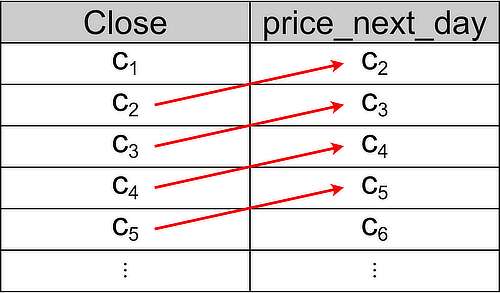

In [9]:
hist_bitcoin['price_next_day'] = hist_bitcoin['Close'].shift(-1)

Once this is done, all rows except the last one will have the Close price for that day and the one for the following day:

In [10]:
hist_bitcoin.tail()

,Open,High,Low,Close,Volume,price_amplitude,7-day-return,SMA_7,SMA_14,SMA_CROSS,price_next_day
Date,,,,,,,,,,,
2023-10-04 00:00:00+00:00,27429.074219,27826.658203,27248.105469,27799.394531,11143355314,2.123277,7.710176,27377.870257,26892.639788,1,27415.912109
2023-10-05 00:00:00+00:00,27798.646484,28091.861328,27375.601562,27415.912109,11877253670,2.616417,2.090321,27434.208147,26953.231166,1,27946.597656
2023-10-06 00:00:00+00:00,27412.123047,28252.537109,27215.552734,27946.597656,13492391599,3.810264,5.443802,27582.047712,27050.876116,1,27968.839844
2023-10-07 00:00:00+00:00,27946.781250,28028.091797,27870.423828,27968.839844,6553044316,0.565718,5.257637,27725.036830,27150.122489,1,27901.521484
2023-10-08 00:00:00+00:00,27970.734375,28099.066406,27763.474609,27901.521484,7616212992,1.208753,-0.424551,27713.289900,27267.600725,1,NaN


In order to effectively determine which variables will be predictors in our model, let's examine their correlation with the target variable "price_next_day":

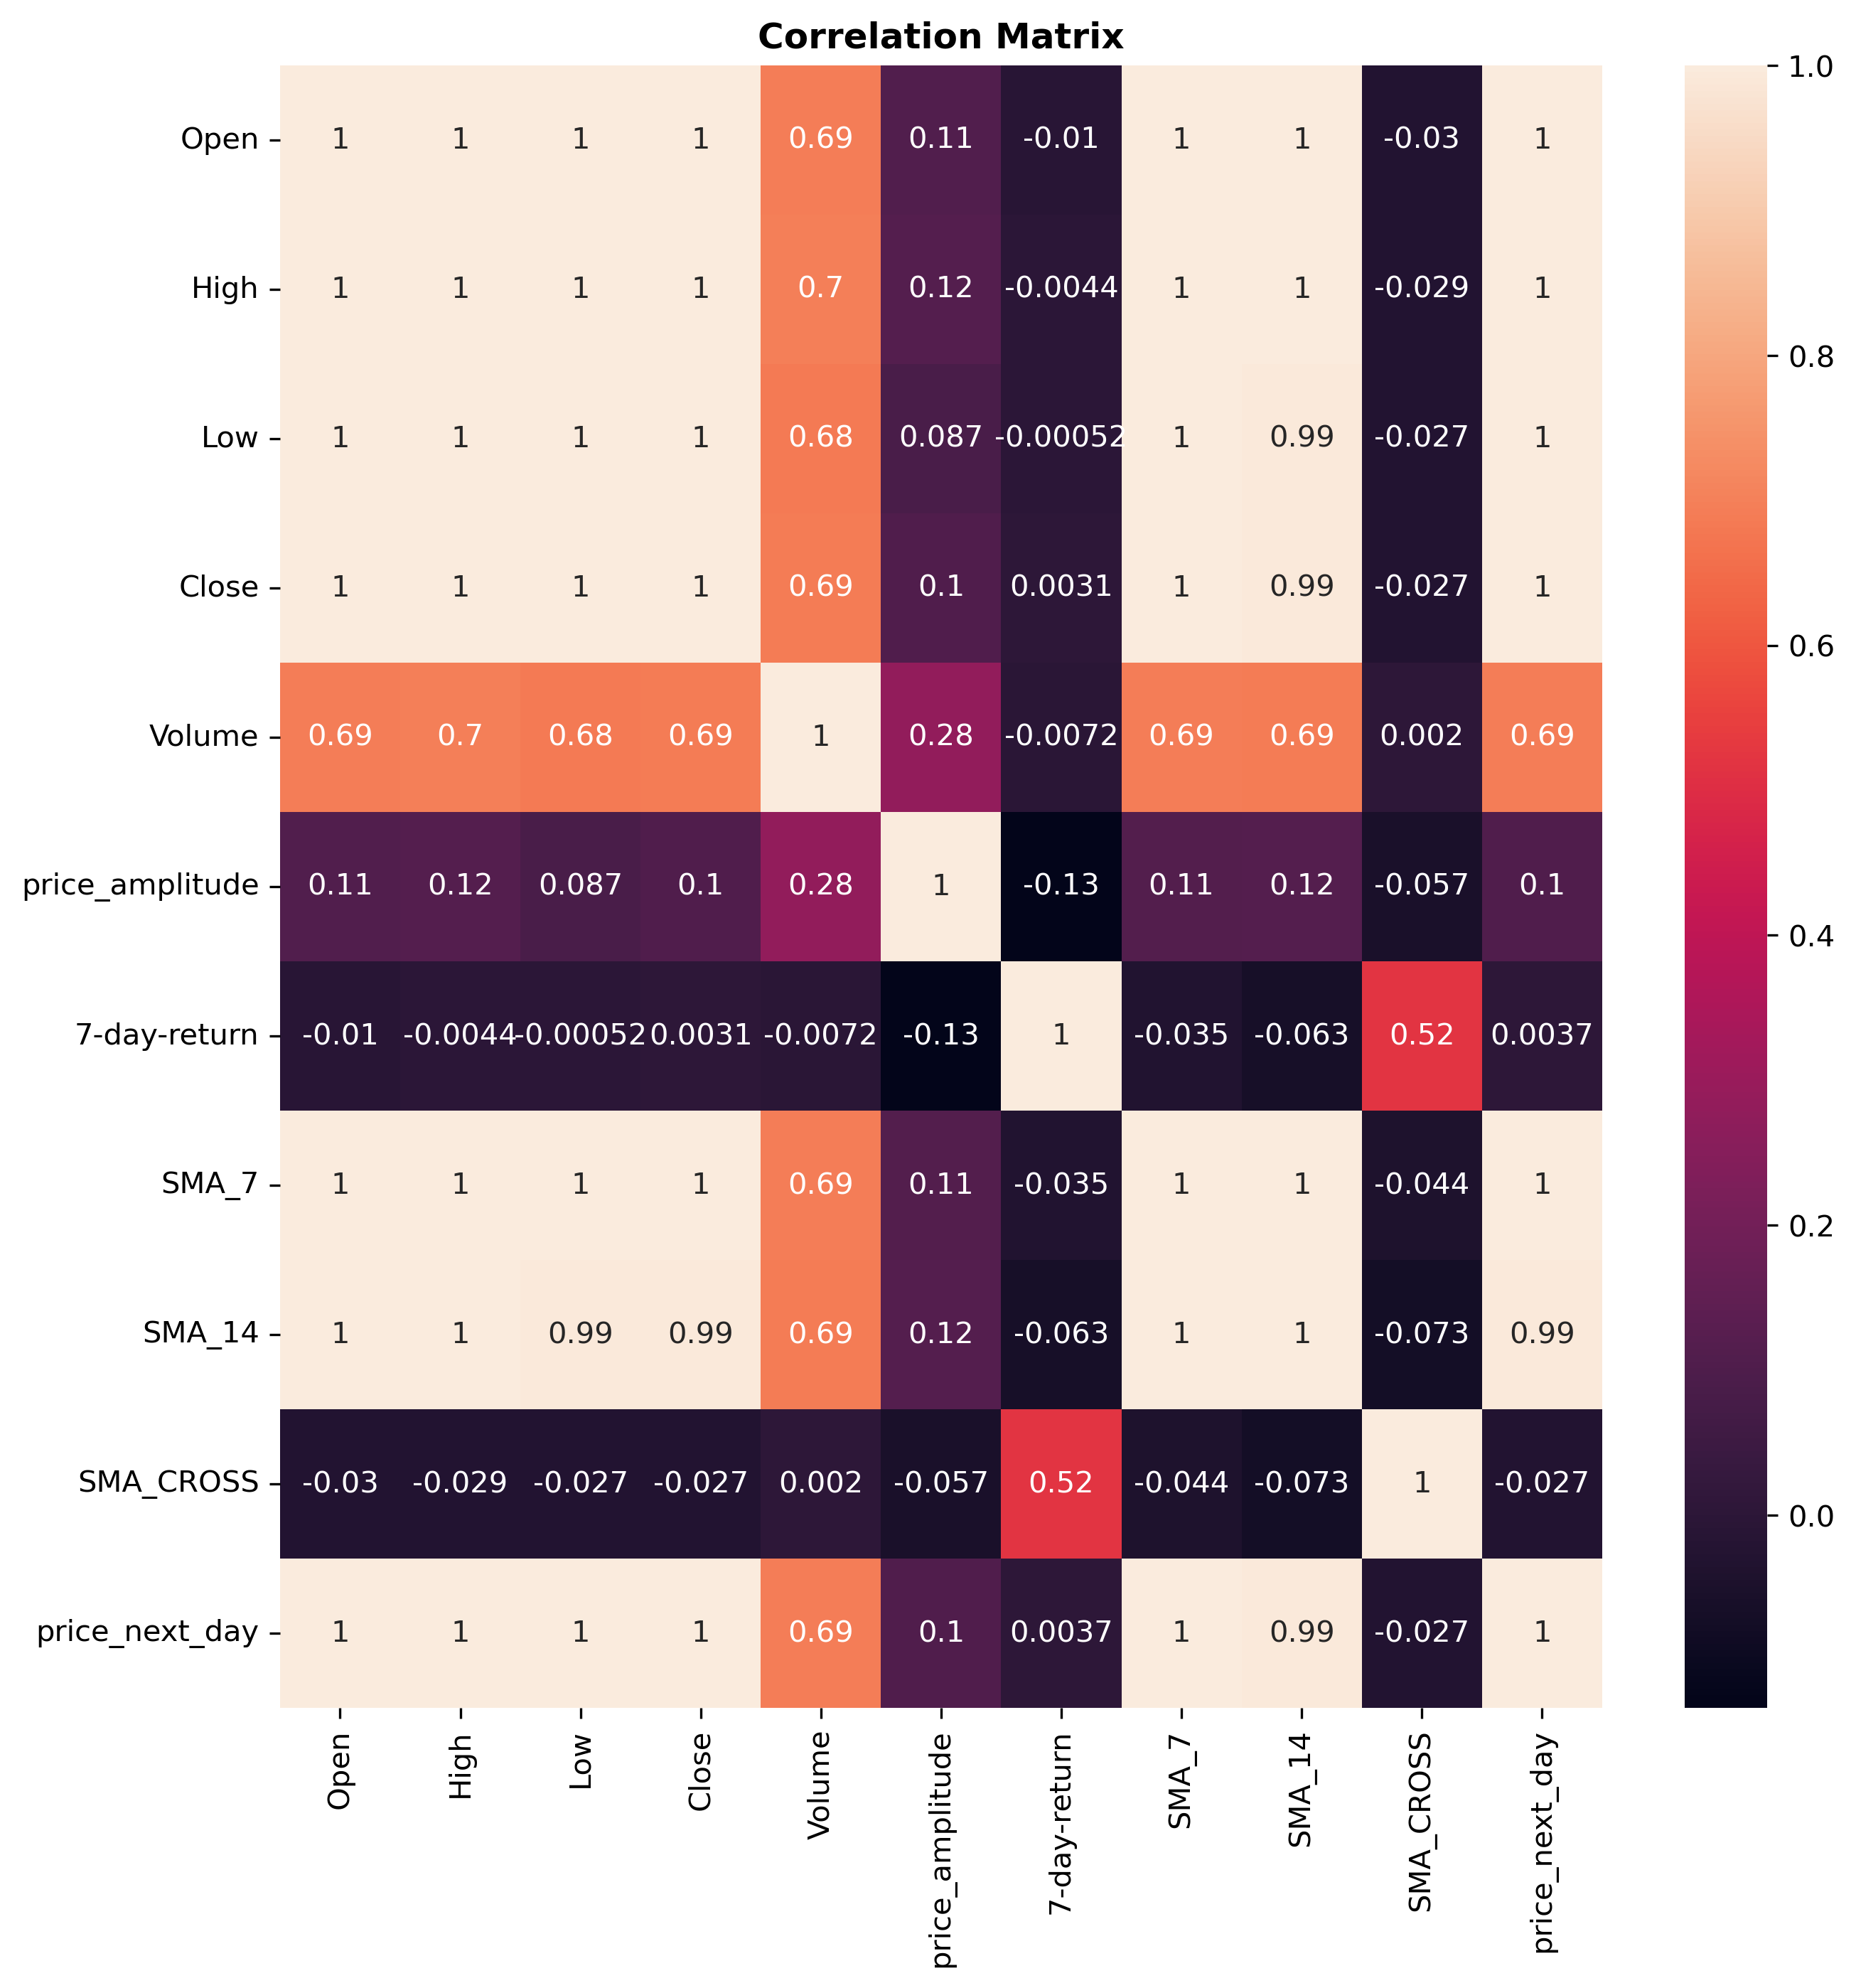

In [11]:
fig, ax = plt.subplots(figsize=[10, 10])
sns.heatmap(hist_bitcoin.corr(), annot=True)
plt.title("Correlation Matrix", fontweight="bold")
plt.show()

At first glance, we have a problem with respect to the variables. As we can see, we have a perfect linear correlation between the variables "Open," "High," "Low," "Close," "SMA_7," "SMA_14," and the target variable "price_next_day." In fact, not only do they have a perfect correlation with the target, but also among themselves. Therefore, it would be advisable to remove some of them to avoid multicollinearity issues.

Since SMA_7 and SMA_14 are the only ones containing past information, we will keep them in the first instance. The rest, except "Close," will be removed:

In [12]:
hist_bitcoin.drop(columns=["Open", "High", "Low"], inplace=True)

The price (Close) of the day will remain as the primary indicator when predicting the price (Close) of the next day:

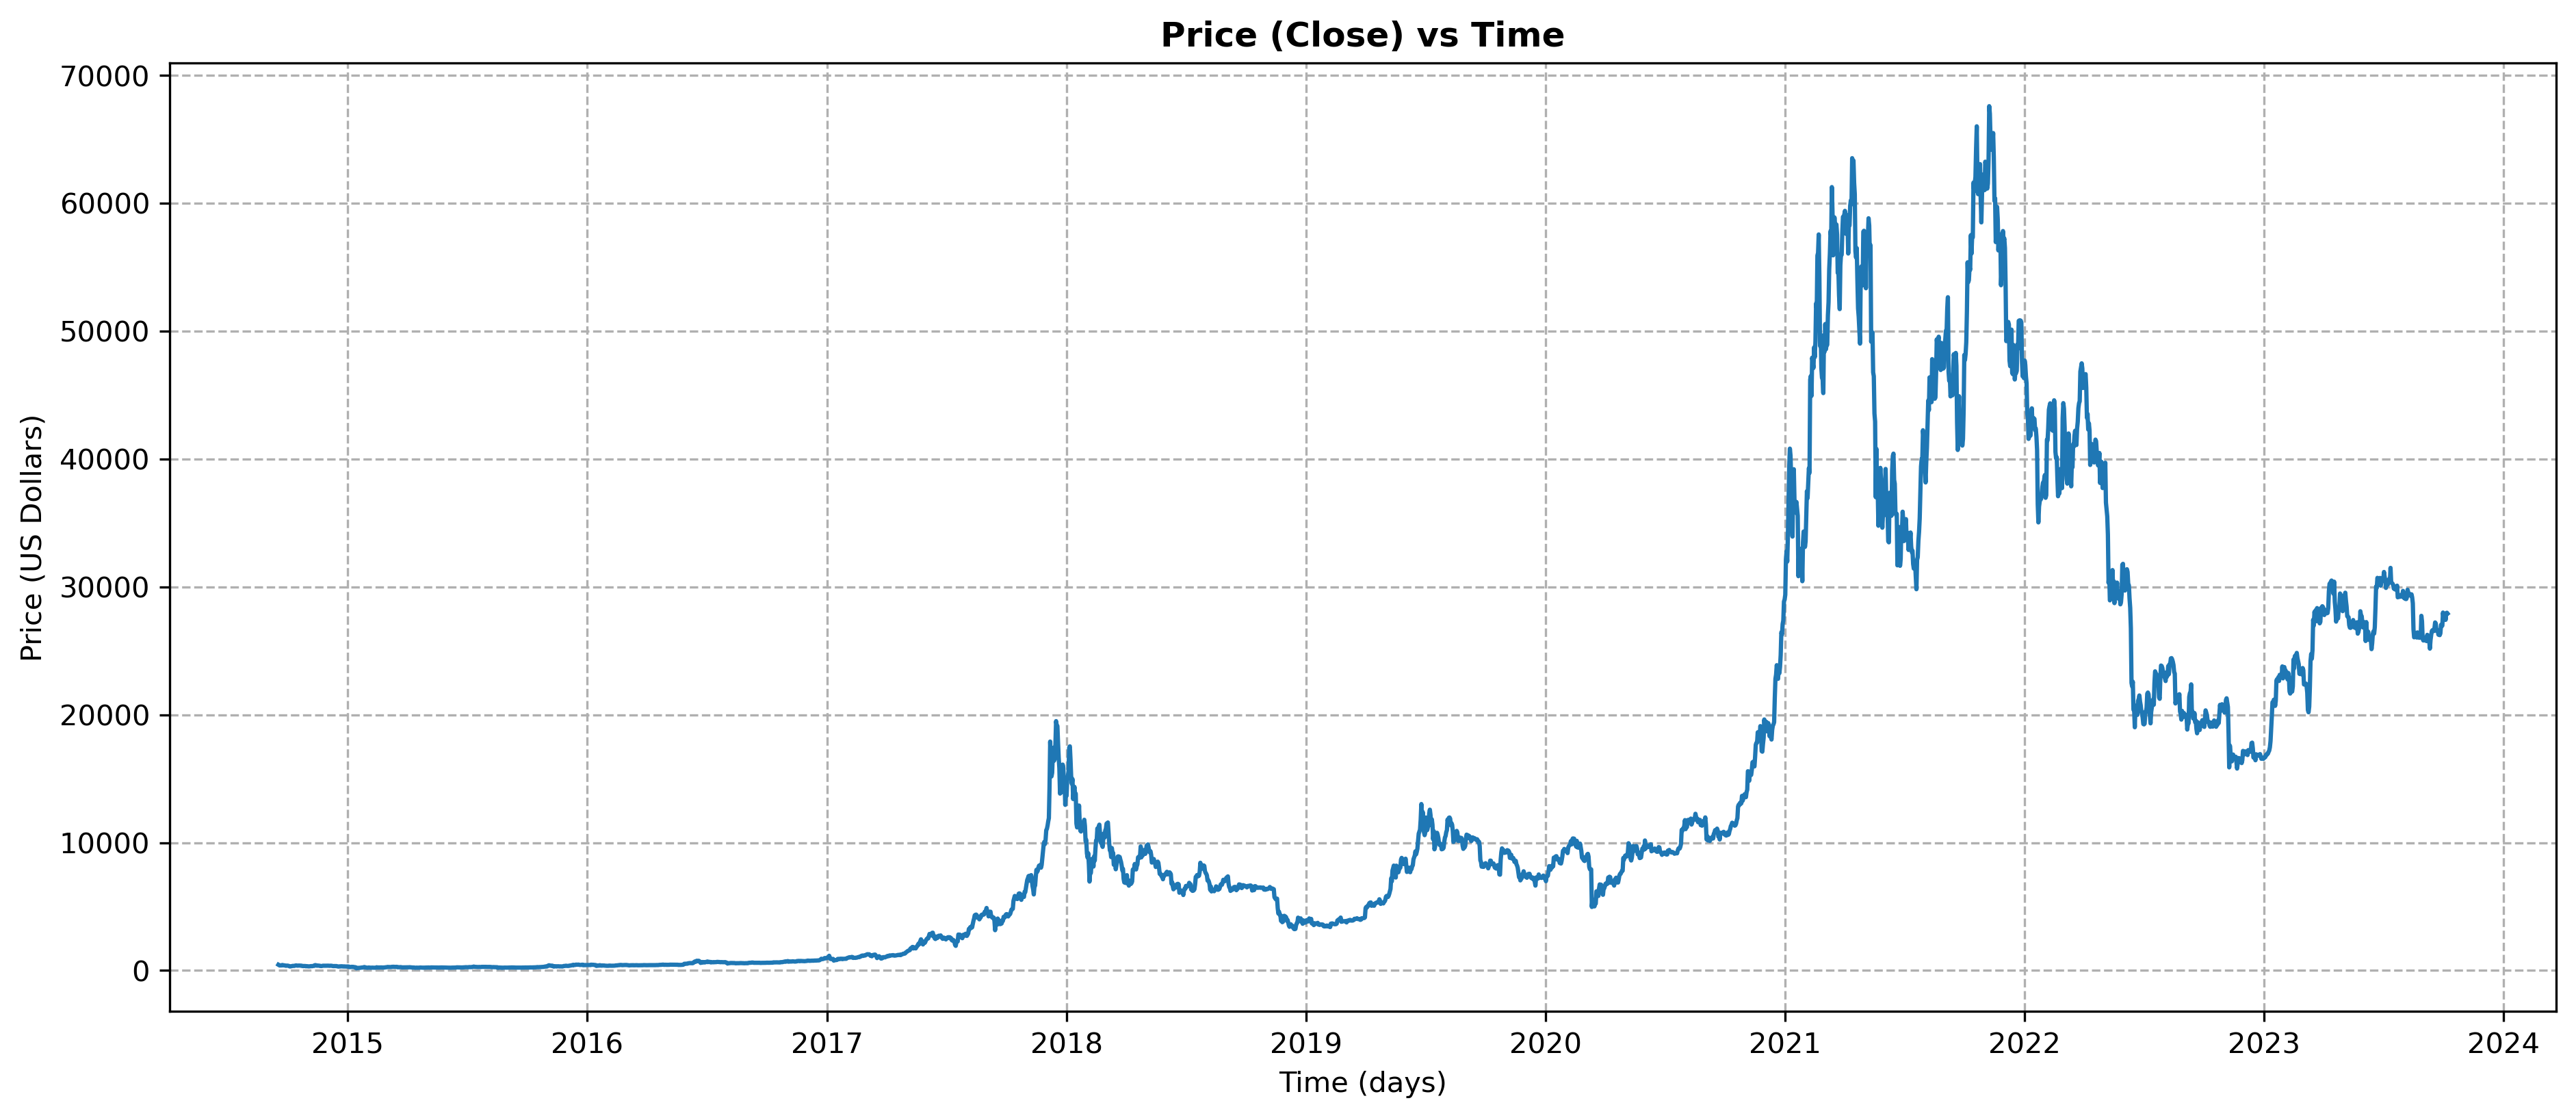

In [13]:
fig, ax = plt.subplots(figsize=[15,6])
ax.plot(hist_bitcoin["Close"])

plt.xlabel("Time (days)")
plt.ylabel("Price (US Dollars)")
plt.title("Price (Close) vs Time", fontweight="bold")
plt.grid(linestyle="dashed")
plt.show()

Having done that, we will save the last day of our dataset. This is the one we will use for the actual prediction of the next day and will be removed from the dataset, as it cannot be used for training or testing:

In [14]:
last_day = hist_bitcoin.drop(columns="price_next_day").iloc[[-1]]

Now, we remove the NaN values:

In [15]:
hist_bitcoin.dropna(inplace=True)

To complete the data preparation before processing, we are going to remove a few rows from the beginning of the dataframe. This is due to our training model. Since we will use windows of 500 temporal data points with a shift of 100 at a time, we need to have a multiple of 100 rows. Therefore, we will remove as many rows from the beginning as the remainder of the integer division of `len(hist_bitcoin)` by 100.

In [16]:
hist_bitcoin = hist_bitcoin[len(hist_bitcoin)%100:]

At this point, we are ready to scale our data. According to the documentation of `SGDRegressor()` in `sklearn`, the model performs better when the data has a zero mean and unit variance, i.e., data that follows a normal distribution. For this reason, we will standardize our data using `StandardScaler()`. Another interesting option could have been scaling using `MinMaxScaler()`, as it preserves the original distribution shape:

In [17]:
scaler = StandardScaler()

X = np.array(hist_bitcoin.drop(columns='price_next_day'))
X = scaler.fit_transform(X)

y = np.array(hist_bitcoin['price_next_day'])

An extremely important point to note is that, once the model has been trained with this scaled data, we must use the exact same scaler (without redefining it) if we want to add new data without retraining the model.

Having said that, we proceed to the training loop. As mentioned at the beginning, we will use the "rolling windows" method; instead of feeding the model with all data points at once, we will gradually provide it with temporal windows of a fixed size and shift. A training scheme might look like this:

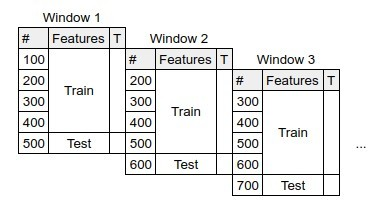

Another important consideration is the use of the `.partial_fit()` method in training our regression model. According to the documentation of `SGDRegressor()`, the use of `.fit()` is recommended for general training, i.e., when the entire dataset (except for the test set) is used as training data. For this reason, when `.fit()` is applied a second time, it discards all previous information, preventing the system from retraining using partial data. All of this is resolved with the `.partial_fit()` method, which is used to retrain the model with new data as it becomes available. It is recommended for "rolling forecast" type of training, where data arrives over time.

In [18]:
SGD = SGDRegressor(shuffle=False)
y_pred_total = []
MAE = []
MSE = []
MAPE = []
for time_lag in range(0, len(X)-400, 100):
    X_train = X[time_lag:400+time_lag]
    y_train = y[time_lag:400+time_lag]
    X_test = X[400+time_lag:500+time_lag]
    y_test = y[400+time_lag:500+time_lag]
    
    SGD.partial_fit(X_train, y_train)

    try:
        y_pred = SGD.predict(X_test)

        y_pred_total.extend(y_pred)

        MAE.append(mean_absolute_error(y_test, y_pred))
        MSE.append(mean_squared_error(y_test, y_pred))
        MAPE.append(mean_absolute_percentage_error(y_test, y_pred))
    except:
        print("No more test points")

Let us see how our model has performed in terms of errors in the different temporal training windows:

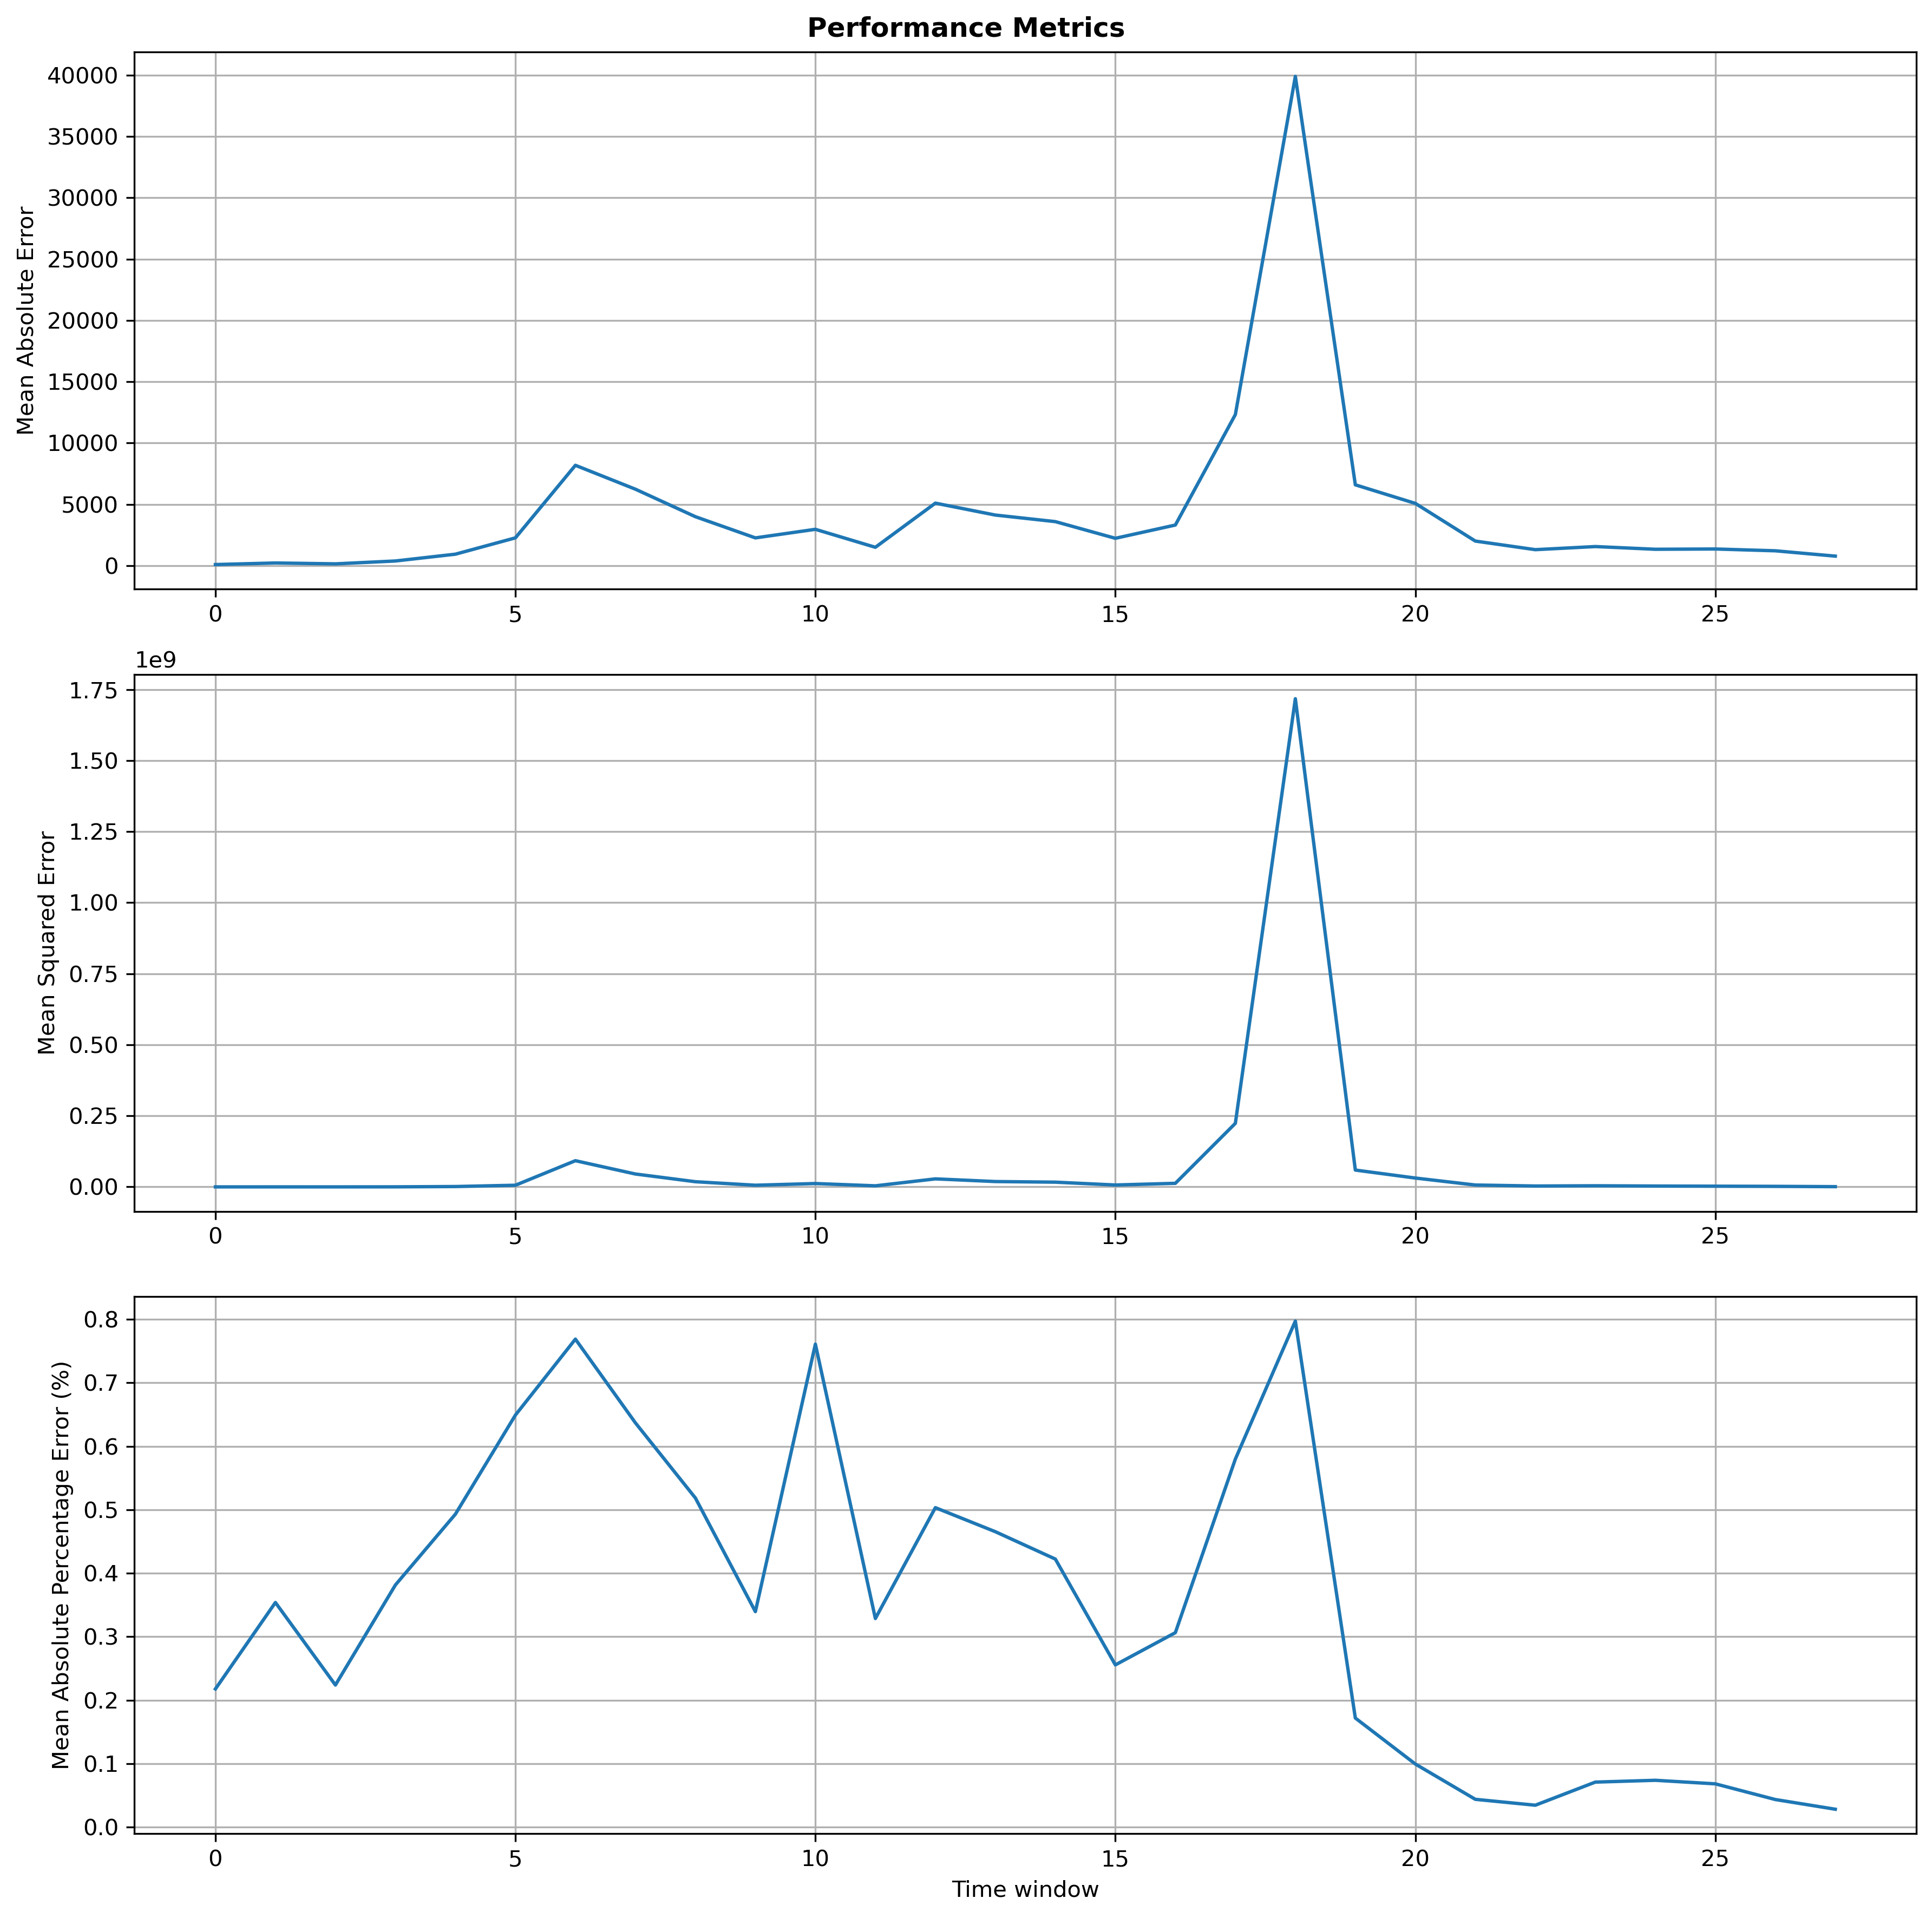

In [19]:
fig, ax = plt.subplots(3, 1, figsize=[12, 12])
plt.xlabel("Time window")

ax[0].plot(MAE)
ax[0].set_ylabel("Mean Absolute Error")
ax[0].grid()

ax[1].plot(MSE)
ax[1].set_ylabel("Mean Squared Error")
ax[1].grid()

ax[2].plot(MAPE)
ax[2].set_ylabel("Mean Absolute Percentage Error (%)")
ax[2].grid()

plt.suptitle("Performance Metrics", fontweight="bold")

plt.tight_layout()
plt.show()

What we see in the previous graphs is that as our model learns, the error gradually decreases. The noticeable sharp increase in error again in the 18th temporal window is due to the abrupt (and unexpected) increase in the price of Bitcoin at the end of 2020 and the beginning of 2021. After this, we can see that the model stabilizes and starts to properly fit the target variable.

To visually check the difference between the predictions and the actual price values, we will introduce the predictions into our dataframe. Naturally, due to the training method, the first 400 values lack predictions; therefore, we fill these with NaN values:

In [20]:
hist_bitcoin["price_next_day_pred"] = np.append(np.full(400, np.nan), y_pred_total)

After this, we can see how the structure of our dataframe looks. In this way, we have "price_next_day" as the actual price and, to its right, "price_next_day_pred" as the prediction made by the model in the successive tests:

In [21]:
hist_bitcoin.tail()

,Close,Volume,price_amplitude,7-day-return,SMA_7,SMA_14,SMA_CROSS,price_next_day,price_next_day_pred
Date,,,,,,,,,
2023-10-03 00:00:00+00:00,27429.978516,11407814187,1.657809,6.523713,27171.202009,26844.969308,1,27799.394531,26668.461936
2023-10-04 00:00:00+00:00,27799.394531,11143355314,2.123277,7.710176,27377.870257,26892.639788,1,27415.912109,26910.042653
2023-10-05 00:00:00+00:00,27415.912109,11877253670,2.616417,2.090321,27434.208147,26953.231166,1,27946.597656,26297.062499
2023-10-06 00:00:00+00:00,27946.597656,13492391599,3.810264,5.443802,27582.047712,27050.876116,1,27968.839844,26815.936968
2023-10-07 00:00:00+00:00,27968.839844,6553044316,0.565718,5.257637,27725.036830,27150.122489,1,27901.521484,26861.289099


Visually, it looks like this:

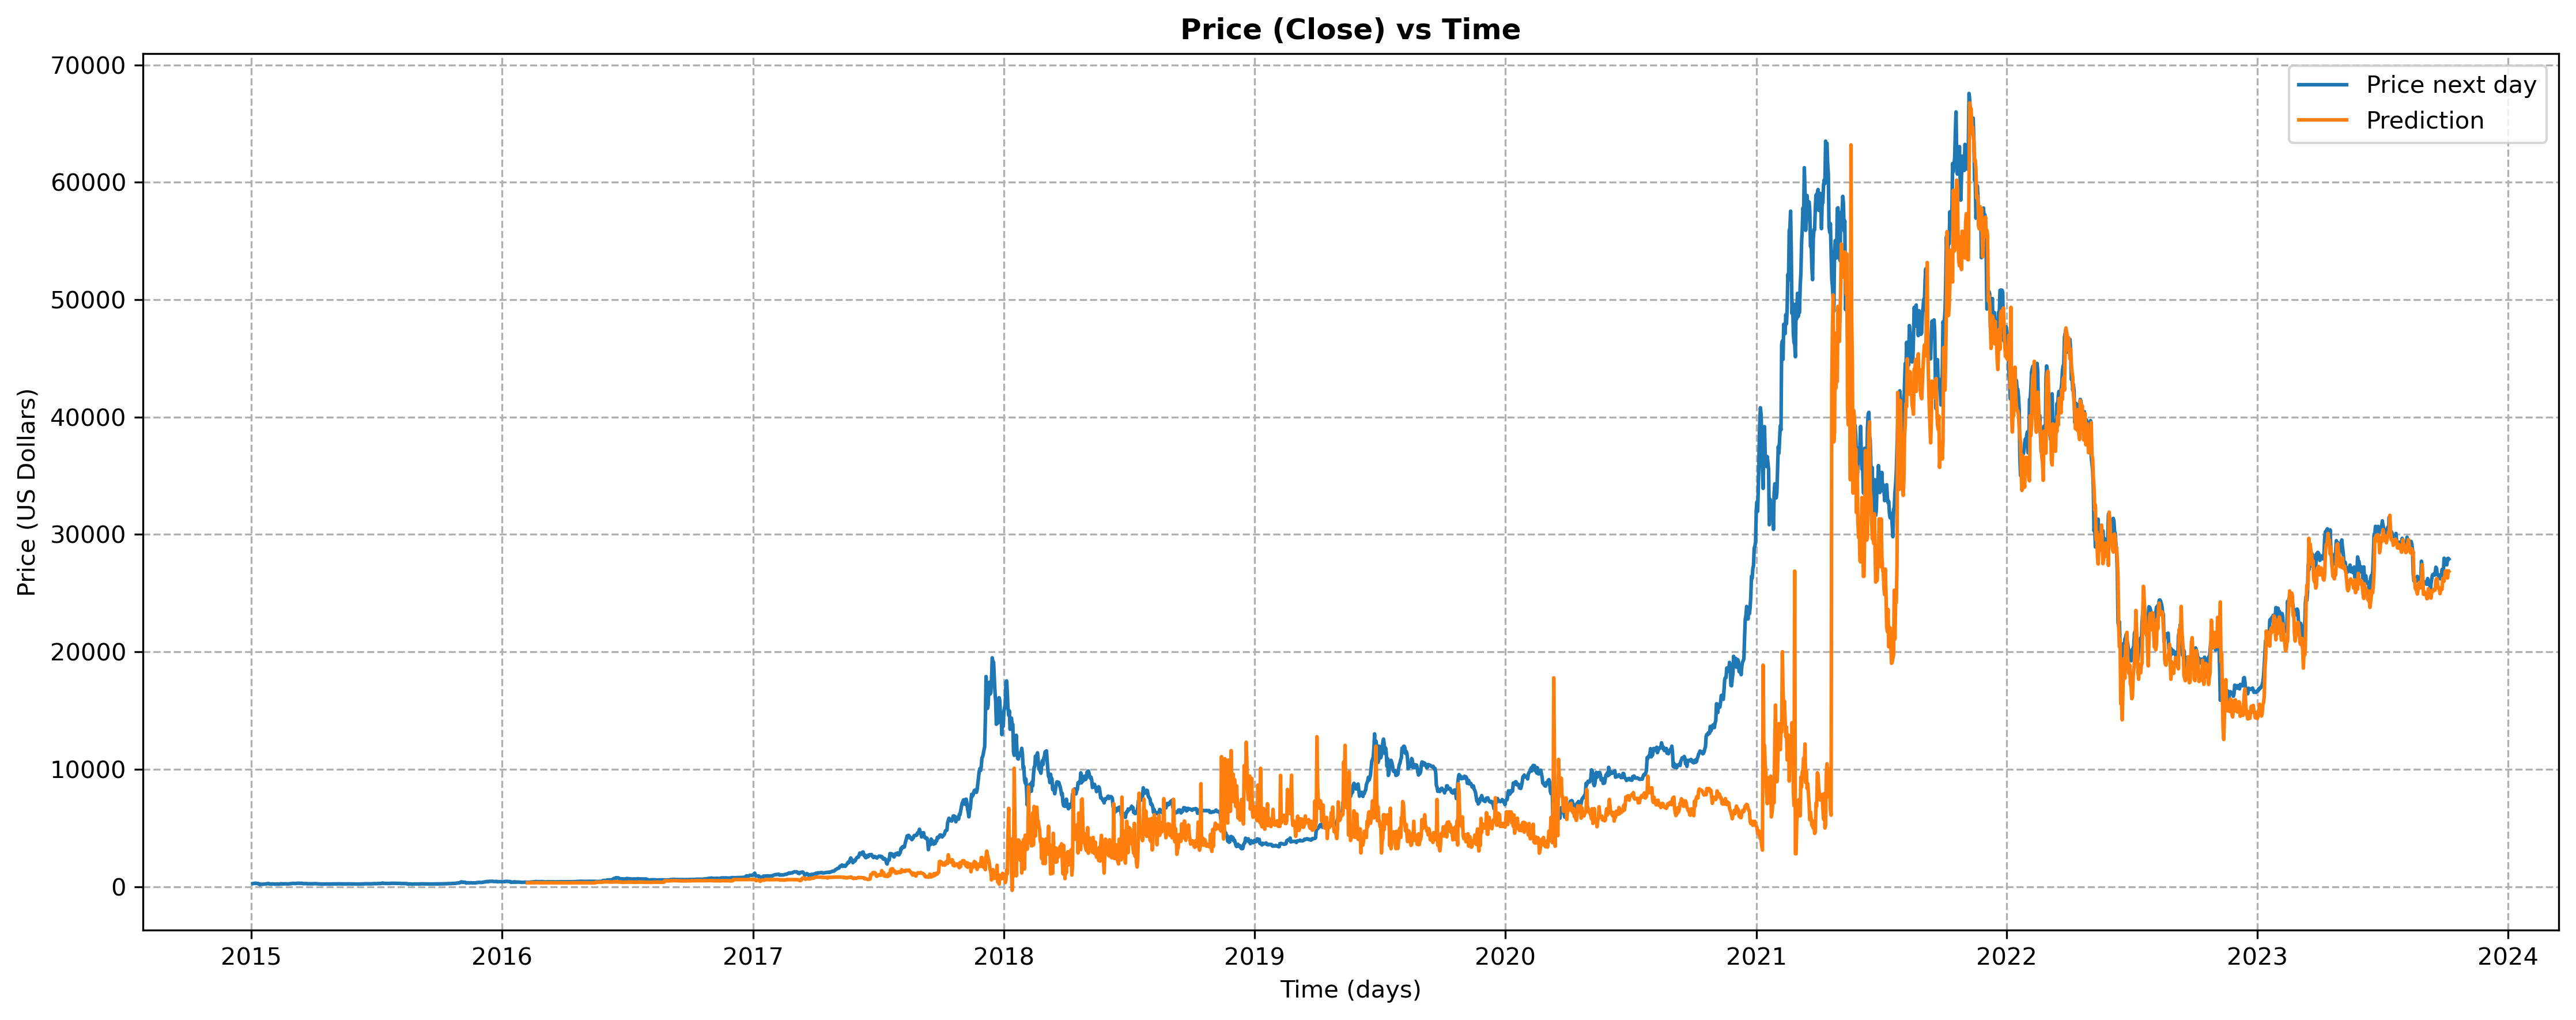

In [22]:
fig, ax = plt.subplots(figsize=[15,6])
ax.plot(hist_bitcoin["price_next_day"], label="Price next day")
ax.plot(hist_bitcoin["price_next_day_pred"], label="Prediction")

plt.xlabel("Time (days)")
plt.ylabel("Price (US Dollars)")
plt.title("Price (Close) vs Time", fontweight="bold")
plt.grid(linestyle="dashed")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

With that done, all that's left is to make the prediction for the next day based on today's data and, hopefully, hope for an accurate prediction to make us rich :)

The first step is to scale today's data using the **same** scaler we used for training:

In [23]:
last_day_scale = scaler.transform(np.array(last_day))

And request our prediction:

In [24]:
last_day

,Close,Volume,price_amplitude,7-day-return,SMA_7,SMA_14,SMA_CROSS
Date,,,,,,,
2023-10-08 00:00:00+00:00,27901.521484,7616212992,1.208753,-0.424551,27713.2899,27267.600725,1


In [25]:
price_tomorrow = SGD.predict(last_day_scale)[0]
print(f"The price for tomorrow is: ${price_tomorrow}")

The price for tomorrow is: $26359.7826273471


### Extra: Prediction using a Neural Network

As for the architecture of the neural network, a relatively standard one within "time series forecasting" has been used. It consists of 4 layers:
- An LSTM layer with 100 network units. Configure `return_sequence` as `True` so that the output of the layer is another sequence of the same length.
- Another LSTM layer, also with 100 network units. But this time, configure `return_sequence` as `False` to return only the last output in the sequence.
- A densely connected neural network layer with 30 network units.
- A densely connected layer specifying the output of 1 network unit, corresponding to the prediction of the price for the next day.

In [26]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(100, return_sequences=True, input_shape=(X.shape[1], 1)),
    tf.keras.layers.LSTM(100, return_sequences=False),
    tf.keras.layers.Dense(30, activation='relu'),  
    tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 100)            40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 30)                3030      
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 124,261
Trainable params: 124,261
Non-trainable params: 0
_________________________________________________________________


As the optimizer, we will use `Adam` as it is another standard for this type of problem. `learning_rate` has been adjusted to its default value of 0.001; however, this has been done explicitly to make it easier to change in further testing. The mean squared error is used as the loss function.

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

From this point, the same principle of training with temporal windows has been applied using the neural network. Early stopping has been configured to stop training prematurely if the loss function value begins to increase during training.

Similarly, 20% of the total training values have been used as a validation set. The `shuffle` parameter has been set to `False` at all times to ensure that the order of the data is not altered.

In [28]:
# Hyperparameters
batch_size = 1
epochs = 10

# Training and evaluation
y_pred_total_rnn = []
MAE = []
MSE = []
MAPE = []

for time_lag in range(0, len(X) - 400, 100):
    X_train = X[time_lag:400+time_lag]
    y_train = y[time_lag:400+time_lag]
    X_test = X[400+time_lag:500+time_lag]
    y_test = y[400+time_lag:500+time_lag]

    # Train the model with early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True)
    
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.2,  # Use a validation set
        shuffle=False,  # Shuffle data if needed
        callbacks=[early_stopping]
    )

    # Predict on the test window
    y_pred = model.predict(X_test)

    y_pred_total_rnn.extend(y_pred)

    MAE.append(mean_absolute_error(y_test, y_pred))
    MSE.append(mean_squared_error(y_test, y_pred))
    MAPE.append(mean_absolute_percentage_error(y_test, y_pred))

Epoch 1/10


320/320 [==============================] - 7s 12ms/step - loss: 20864.5137 - val_loss: 22273.5117
Epoch 2/10
320/320 [==============================] - 3s 8ms/step - loss: 1229.9426 - val_loss: 16702.0352
Epoch 3/10
320/320 [==============================] - 3s 8ms/step - loss: 1342.8099 - val_loss: 15578.8857
Epoch 4/10
320/320 [==============================] - 3s 8ms/step - loss: 1361.8706 - val_loss: 14848.8076
Epoch 5/10
320/320 [==============================] - 3s 8ms/step - loss: 1373.0919 - val_loss: 14356.2129
Epoch 6/10
320/320 [==============================] - 3s 8ms/step - loss: 1380.1312 - val_loss: 14018.7422
Epoch 7/10
320/320 [==============================] - 3s 9ms/step - loss: 1384.7095 - val_loss: 13786.3652
Epoch 8/10
320/320 [==============================] - 3s 8ms/step - loss: 1387.7533 - val_loss: 13626.4502
Epoch 9/10
320/320 [==============================] - 2s 8ms/step - loss: 1389.8053 - val_loss: 13517.0137
Epoch 10/10
4/4 [=============================

Let us see how our model has performed in terms of errors in the different temporal training windows:

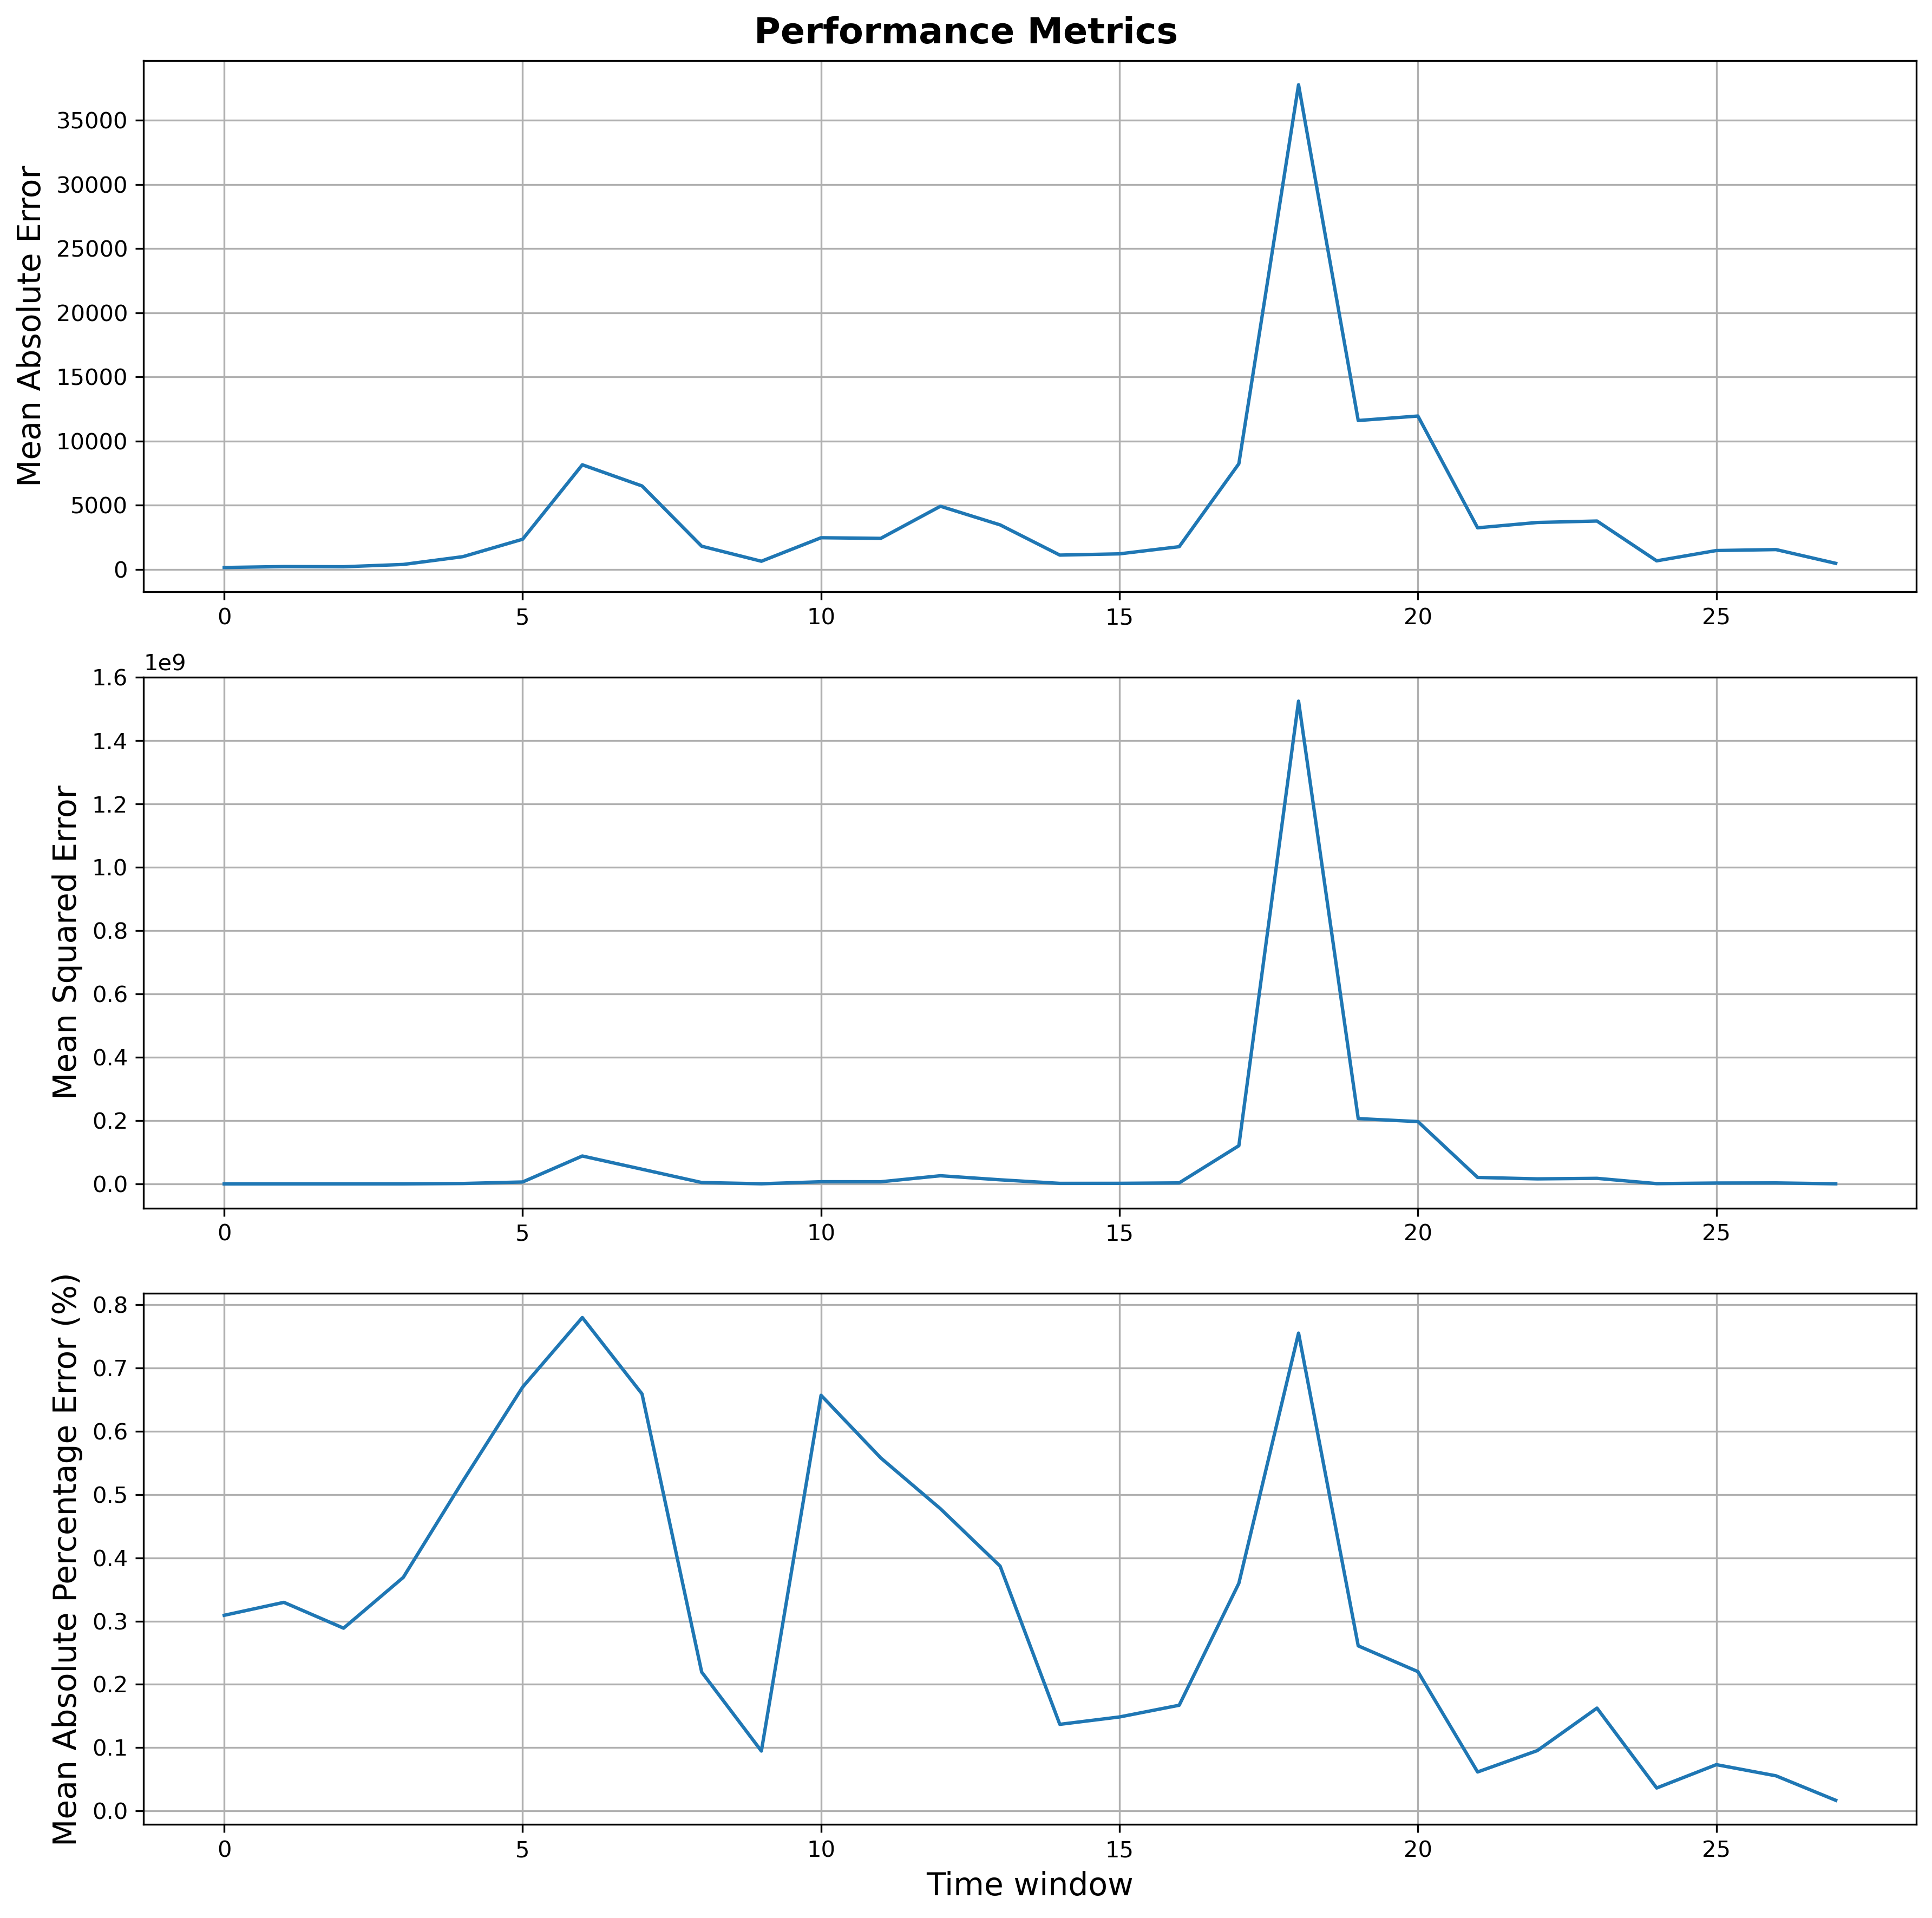

In [29]:
fig, ax = plt.subplots(3, 1, figsize=[12, 12])
plt.xlabel("Time window", fontsize=14)

ax[0].plot(MAE)
ax[0].set_ylabel("Mean Absolute Error", fontsize=14)
ax[0].grid()

ax[1].plot(MSE)
ax[1].set_ylabel("Mean Squared Error", fontsize=14)
ax[1].grid()

ax[2].plot(MAPE)
ax[2].set_ylabel("Mean Absolute Percentage Error (%)", fontsize=14)
ax[2].grid()

plt.suptitle("Performance Metrics", fontweight="bold", fontsize=16)

plt.tight_layout()
plt.show()

We add, just as we did with the predictions from the linear regression model, the values predicted by the neural network to our Bitcoin price dataframe:

In [30]:
hist_bitcoin["price_next_day_pred_RNN"] = np.append(np.full(400, np.nan), y_pred_total_rnn)

In [31]:
hist_bitcoin.tail()

,Close,Volume,price_amplitude,7-day-return,SMA_7,SMA_14,SMA_CROSS,price_next_day,price_next_day_pred,price_next_day_pred_RNN
Date,,,,,,,,,,
2023-10-03 00:00:00+00:00,27429.978516,11407814187,1.657809,6.523713,27171.202009,26844.969308,1,27799.394531,26668.461936,27925.386719
2023-10-04 00:00:00+00:00,27799.394531,11143355314,2.123277,7.710176,27377.870257,26892.639788,1,27415.912109,26910.042653,28188.957031
2023-10-05 00:00:00+00:00,27415.912109,11877253670,2.616417,2.090321,27434.208147,26953.231166,1,27946.597656,26297.062499,27833.548828
2023-10-06 00:00:00+00:00,27946.597656,13492391599,3.810264,5.443802,27582.047712,27050.876116,1,27968.839844,26815.936968,28263.867188
2023-10-07 00:00:00+00:00,27968.839844,6553044316,0.565718,5.257637,27725.036830,27150.122489,1,27901.521484,26861.289099,28270.773438


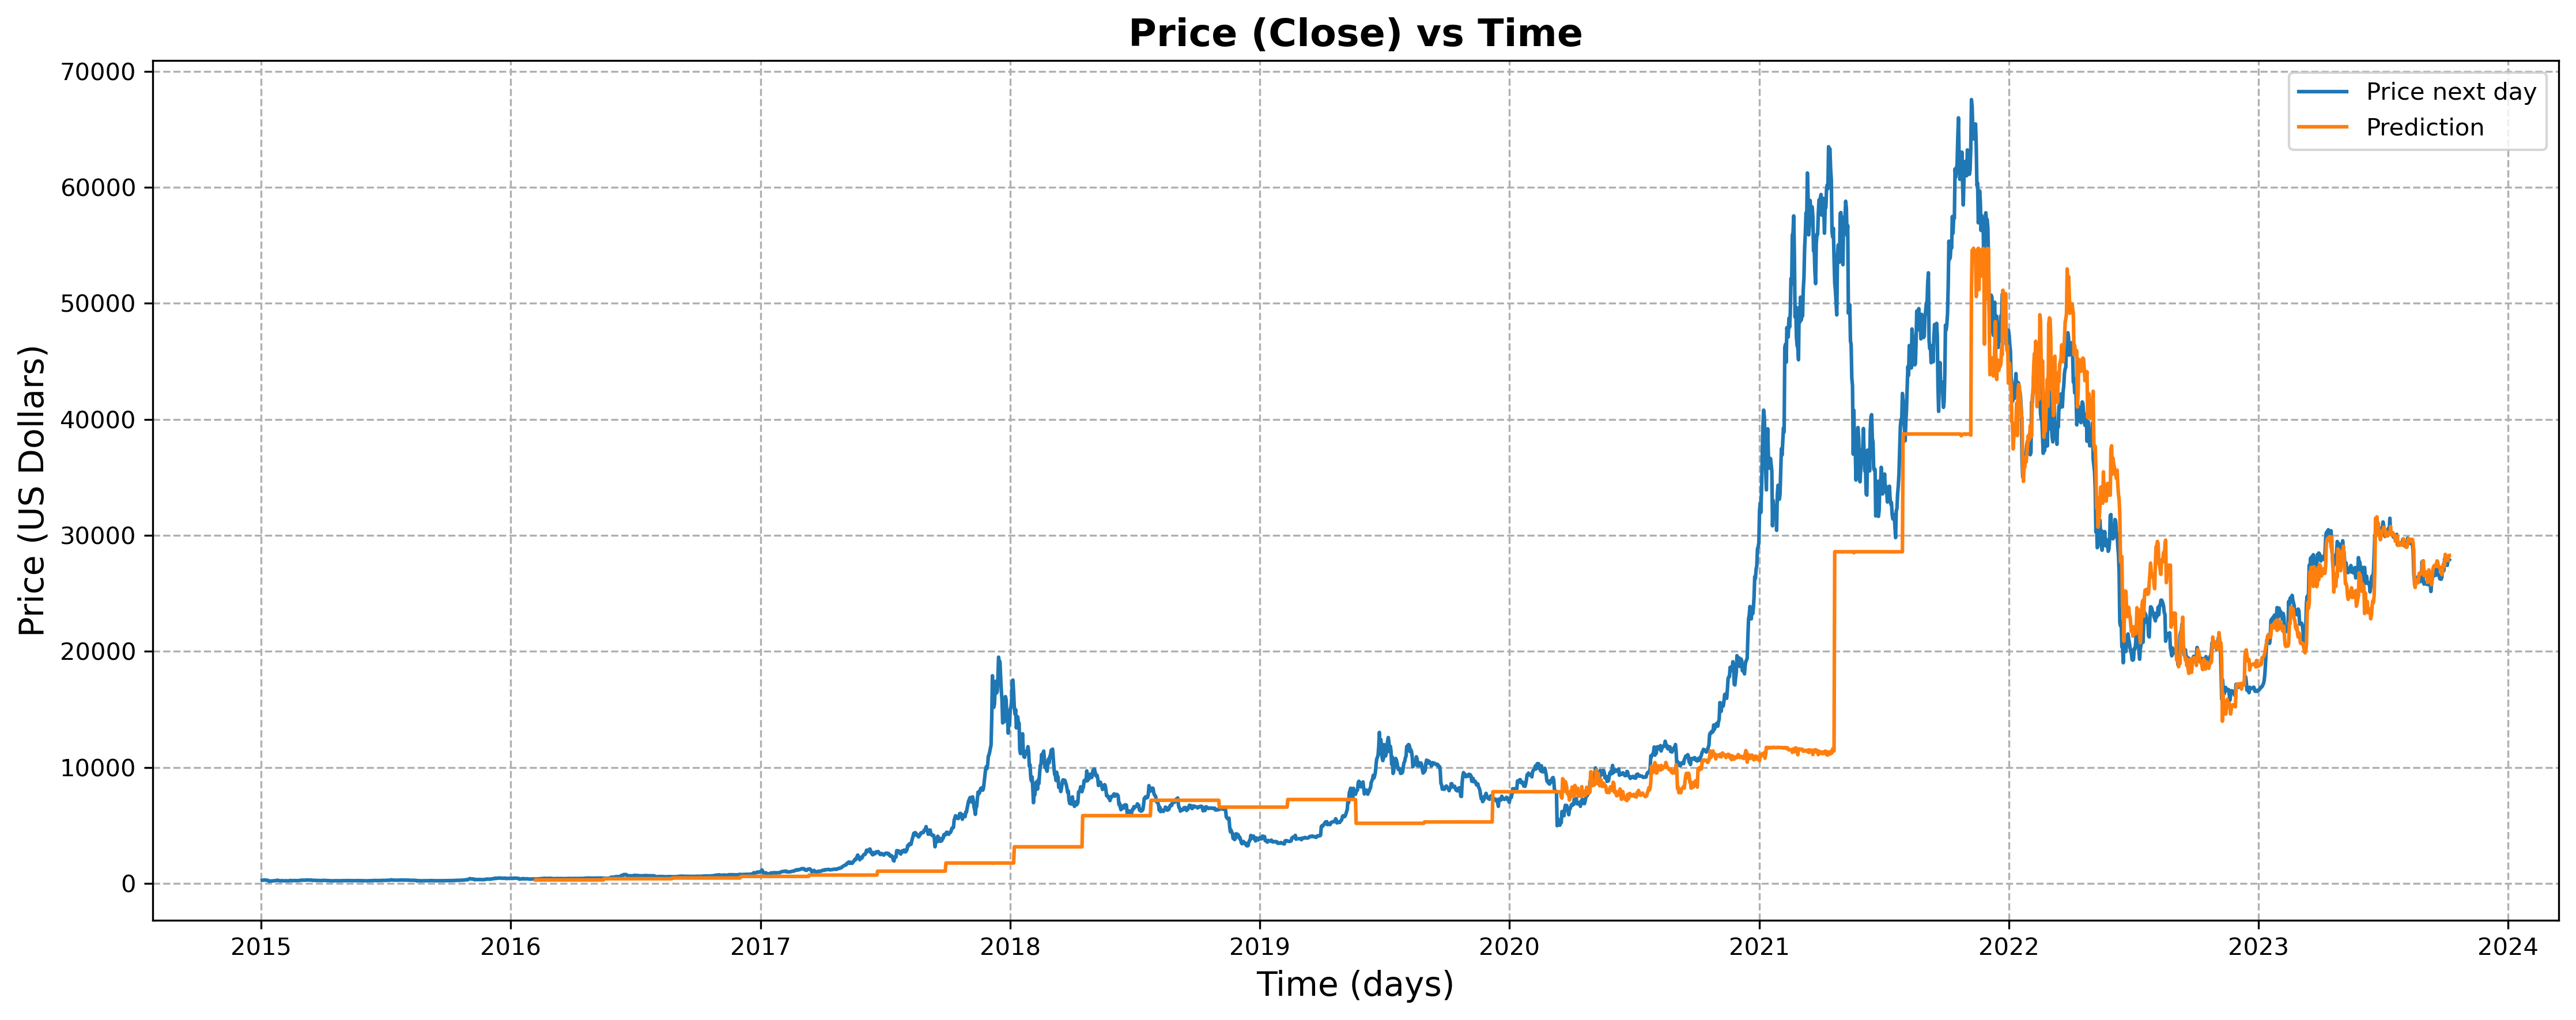

In [32]:
fig, ax = plt.subplots(figsize=[15,6])
ax.plot(hist_bitcoin["price_next_day"], label="Price next day")
ax.plot(hist_bitcoin["price_next_day_pred_RNN"], label="Prediction")

plt.xlabel("Time (days)", fontsize=14)
plt.ylabel("Price (US Dollars)",fontsize=14)
plt.title("Price (Close) vs Time", fontweight="bold", fontsize=16)
plt.grid(linestyle="dashed")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

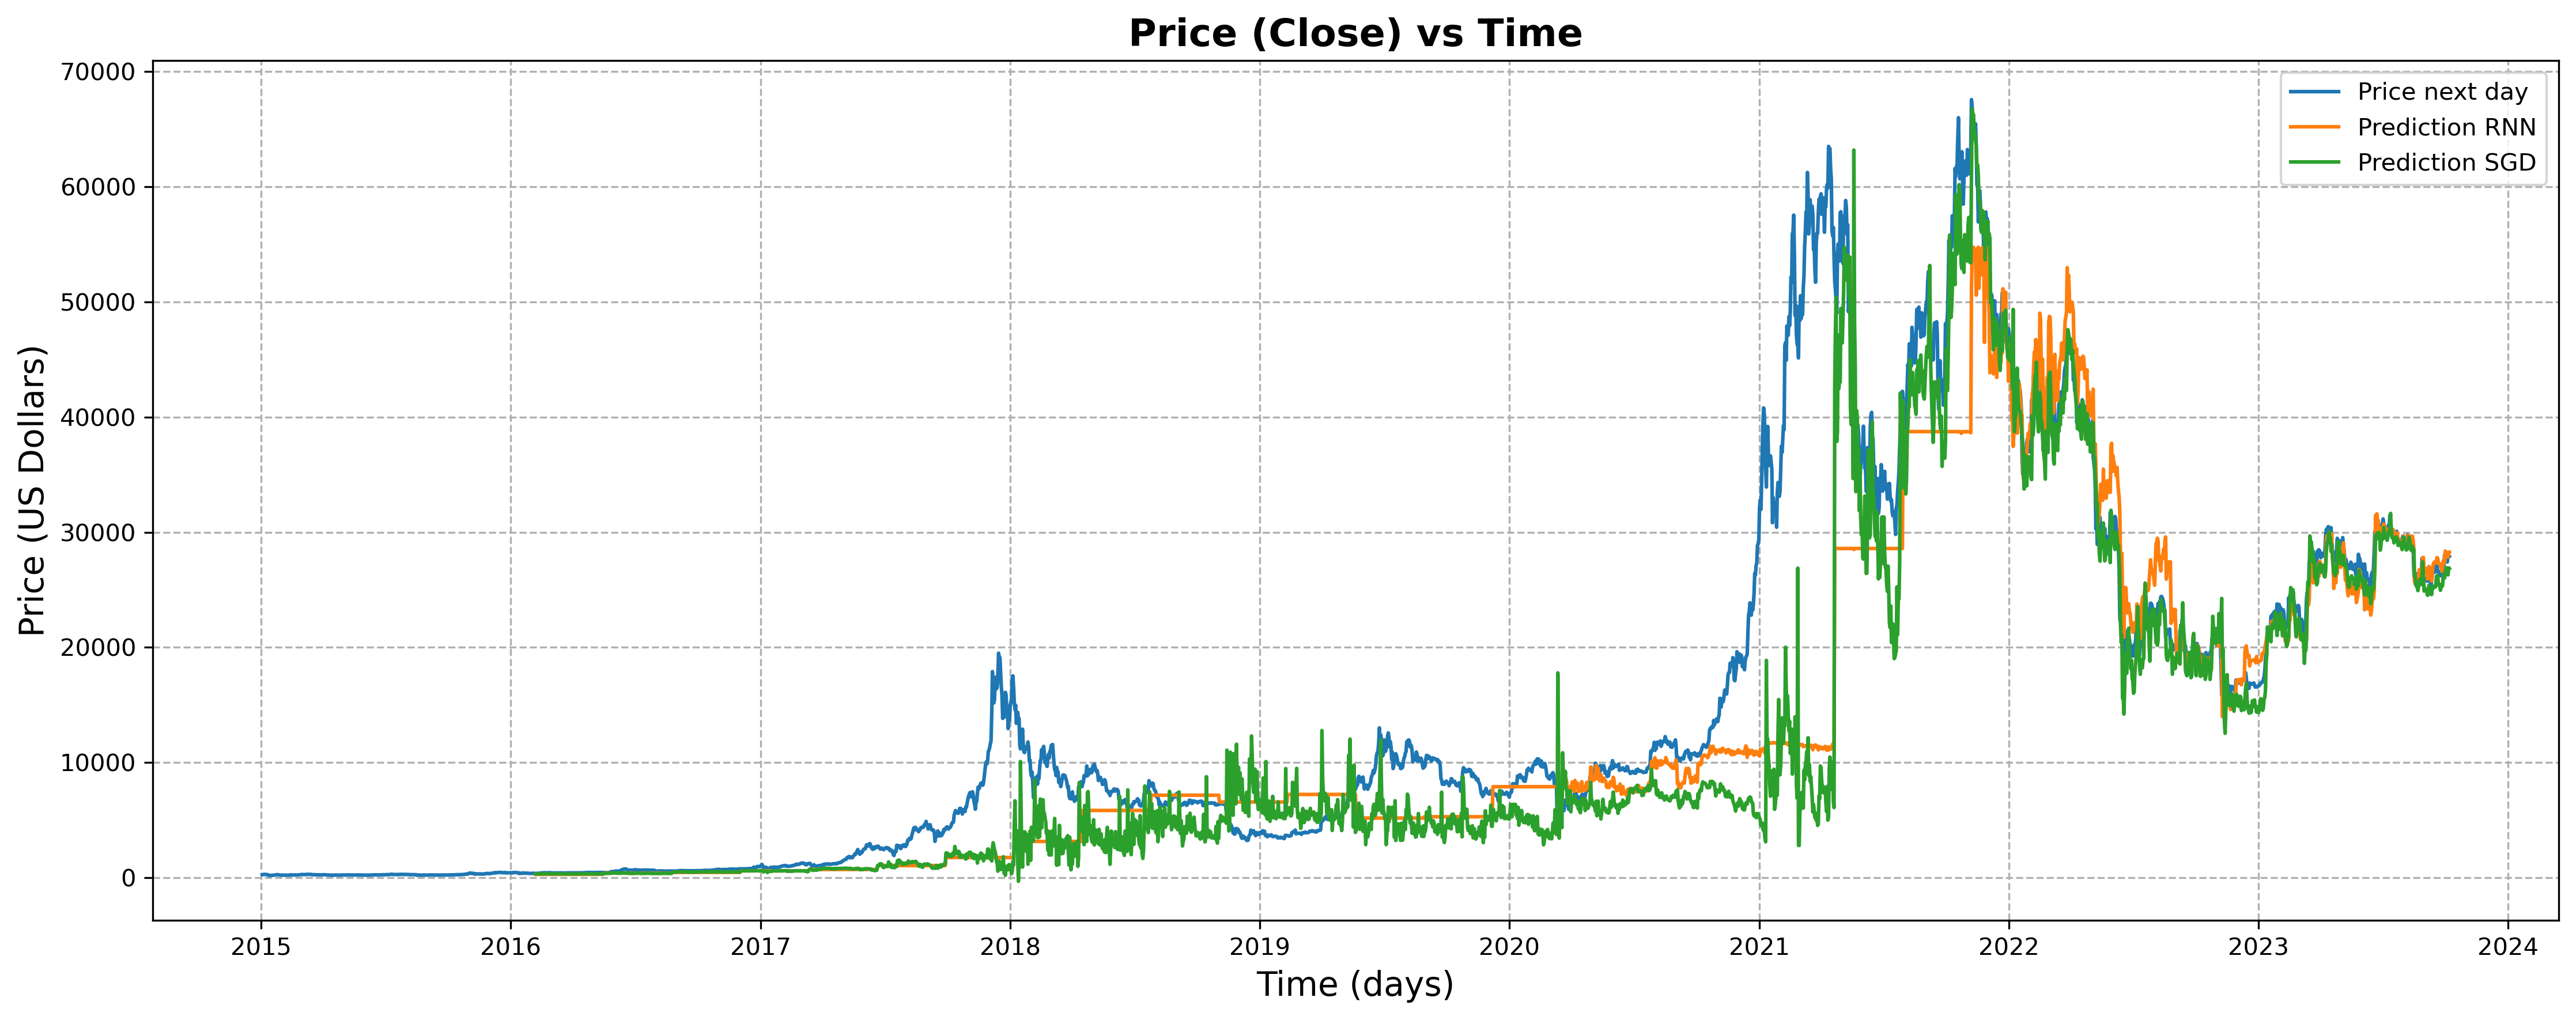

In [33]:
fig, ax = plt.subplots(figsize=[15,6])
ax.plot(hist_bitcoin["price_next_day"], label="Price next day")
ax.plot(hist_bitcoin["price_next_day_pred_RNN"], label="Prediction RNN")
ax.plot(hist_bitcoin["price_next_day_pred"], label="Prediction SGD")

plt.xlabel("Time (days)", fontsize=14)
plt.ylabel("Price (US Dollars)",fontsize=14)
plt.title("Price (Close) vs Time", fontweight="bold", fontsize=16)
plt.grid(linestyle="dashed")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

In [34]:
price_tomorrow = model.predict(last_day_scale)[0][0]
print(f"The price for tomorrow is: ${price_tomorrow}")

1/1 [==============================] - 0s 33ms/step
The price for tomorrow is: $28127.9921875


In [35]:
#model.save('Bitcoin_prediction.h5')